In [2]:
import numpy as np
import os
import torch
import random
from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


In [3]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()


In [4]:
urdf_path = os.path.join("a1.urdf")
device = "cpu"
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

learnable_robot_model.make_link_param_learnable(
    "FR_hip", "trans", UnconstrainedTensor(dim1=1, dim2=3)
)
learnable_robot_model.make_link_param_learnable(
        "FR_thigh_shoulder", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_thigh", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_calf", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_foot", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_hip", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh_shoulder", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_calf", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_foot", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_hip", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh_shoulder", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_calf", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_foot", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_hip", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh_shoulder", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_calf", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_foot", "trans", UnconstrainedTensor(dim1=1, dim2=3)
    )

# learnable_robot_model.print_learnable_params()
learnable_robot_model.compute_forward_kinematics(torch.zeros((1,12)),"FR_foot")

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

(tensor([[ 0.154, -0.005, -0.472]], grad_fn=<AddBackward0>),
 tensor([[0., 0., 0., 1.]], grad_fn=<CopySlices>))

In [5]:
target_ee = torch.rand((1,3))*3

In [6]:
joint_angles = torch.rand((1, 12), requires_grad=True)
optimizer = torch.optim.Adam([joint_angles] + list(learnable_robot_model.parameters()), lr=1e-2)
for _ in range(1000):
    optimizer.zero_grad()
    cur_ee = learnable_robot_model.compute_forward_kinematics(joint_angles, "FR_foot")[0]
    loss = torch.sum(torch.abs(cur_ee - target_ee))
    print(loss)
    loss.backward()
    optimizer.step()


tensor(4.567, grad_fn=<SumBackward0>)
tensor(4.480, grad_fn=<SumBackward0>)
tensor(4.394, grad_fn=<SumBackward0>)
tensor(4.309, grad_fn=<SumBackward0>)
tensor(4.225, grad_fn=<SumBackward0>)
tensor(4.141, grad_fn=<SumBackward0>)
tensor(4.057, grad_fn=<SumBackward0>)
tensor(3.974, grad_fn=<SumBackward0>)
tensor(3.891, grad_fn=<SumBackward0>)
tensor(3.807, grad_fn=<SumBackward0>)
tensor(3.723, grad_fn=<SumBackward0>)
tensor(3.638, grad_fn=<SumBackward0>)
tensor(3.553, grad_fn=<SumBackward0>)
tensor(3.468, grad_fn=<SumBackward0>)
tensor(3.381, grad_fn=<SumBackward0>)
tensor(3.294, grad_fn=<SumBackward0>)
tensor(3.207, grad_fn=<SumBackward0>)
tensor(3.118, grad_fn=<SumBackward0>)
tensor(3.030, grad_fn=<SumBackward0>)
tensor(2.940, grad_fn=<SumBackward0>)
tensor(2.850, grad_fn=<SumBackward0>)
tensor(2.759, grad_fn=<SumBackward0>)
tensor(2.668, grad_fn=<SumBackward0>)
tensor(2.576, grad_fn=<SumBackward0>)
tensor(2.483, grad_fn=<SumBackward0>)
tensor(2.390, grad_fn=<SumBackward0>)
tensor(2.296

In [7]:
import numpy as np
from roboticstoolbox.robot.ERobot import ERobot
from math import pi
class RobotXML(ERobot):

    def __init__(self):

        links, name, urdf_string, urdf_filepath = self.URDF_read(
            "/Users/aman/Library/Mobile Documents/com~apple~CloudDocs/Work/UCSD/Research - Yip/DiffRobotA1/a1.urdf"
        )

        super().__init__(
            links,
            name=name,
            urdf_string=urdf_string,
            urdf_filepath=urdf_filepath,
        )

        self.manufacturer = "File Import"

        # zero angles
        self.addconfiguration("qz", np.zeros(12))


robot = RobotXML()
print(robot)

ERobot: a1 (by File Import), 12 joints (RRRRRRRRRRRR), 9 branches, dynamics, geometry, collision
┌─────┬────────────────────┬───────┬──────────┬──────────────────────────────────┐
│link │        link        │ joint │  parent  │       ETS: parent to link        │
├─────┼────────────────────┼───────┼──────────┼──────────────────────────────────┤
│   0 │ base               │       │ BASE     │                                  │
│   1 │ trunk              │       │ base     │ SE3()                            │
│   2 │ @imu_link          │       │ trunk    │ SE3()                            │
│   3 │ FR_hip             │     0 │ trunk    │ SE3(0.1805, -0.047, 0) ⊕ Rx(q0)  │
│   4 │ @FR_thigh_shoulder │       │ FR_hip   │ SE3(0, -0.081, 0)                │
│   5 │ FR_thigh           │     1 │ FR_hip   │ SE3(0, -0.0838, 0) ⊕ Ry(q1)      │
│   6 │ FR_calf            │     2 │ FR_thigh │ SE3(0, 0, -0.2) ⊕ Ry(q2)         │
│   7 │ @FR_foot           │       │ FR_calf  │ SE3(0, 0, -0.2)          

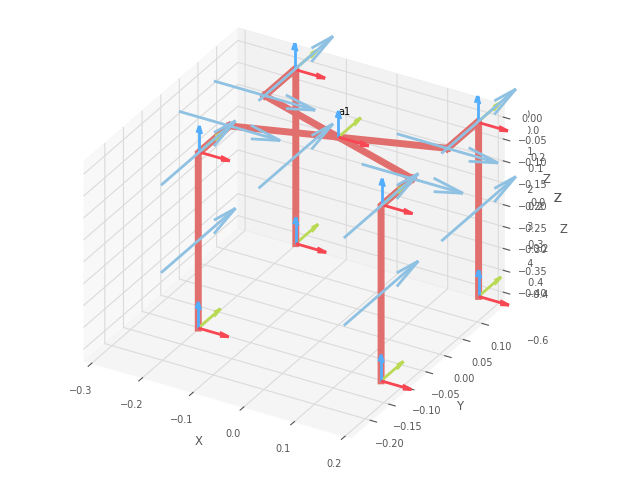

PyPlot3D backend, t = 0.05, scene:
  a1

In [16]:
%matplotlib widget
#Note for some reaso when you update one plot they both update
robot.plot(robot.configs["qz"], backend="pyplot")

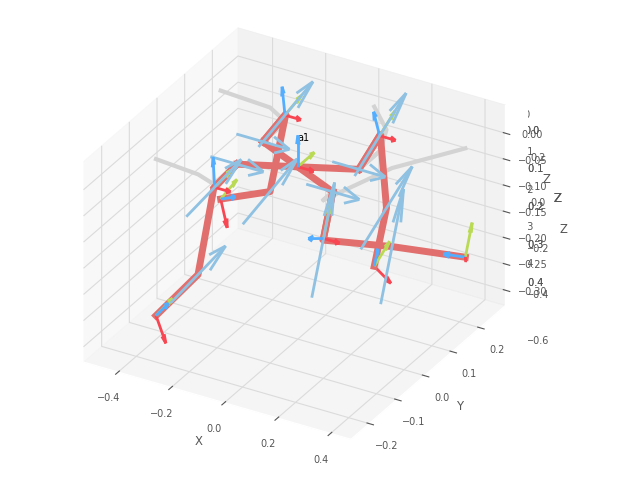

PyPlot3D backend, t = 0.05, scene:
  a1

In [17]:
robot.plot(joint_angles.detach().numpy(), backend = "pyplot")

In [14]:
joint_angles

tensor([[ 1.145, -0.466, -0.327,  0.375,  0.256,  0.325,  0.090,  0.394,  0.607,
          0.174,  0.474,  0.858]], requires_grad=True)